In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sktime.forecasting.model_selection import temporal_train_test_split

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sktime.transformations.series.boxcox import BoxCoxTransformer
from sktime.transformations.series.impute import Imputer
from sktime.transformations.series.detrend import Detrender
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sktime.transformations.base import BaseTransformer

from sktime.transformations.compose import FeatureUnion
from sktime.transformations.series.summarize import WindowSummarizer
from sktime.transformations.series.fourier import FourierFeatures


from catboost import CatBoostRegressor
import shap as sp

from sktime.forecasting.exp_smoothing import ExponentialSmoothing

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
pd.options.display.max_columns = None

In [3]:
df = pd.read_csv('daily-website-visitors.csv')[["Date", "Page.Loads", "Unique.Visits", "First.Time.Visits", "Returning.Visits"]]

df = df.rename(columns={"Date": 'ds', 
                        "Page.Loads": 'y1',
                        "Unique.Visits": 'y2',
                        "First.Time.Visits": 'y3',
                        "Returning.Visits": 'y4'
                       })

In [4]:
targets = ['y1', 'y2', 'y3', 'y4']

In [5]:
df['ds'] = pd.to_datetime(df.ds, yearfirst = True)

for target in targets : 
    df[target] = df[target].str.replace(',','.').astype("float")

df = df.set_index('ds')
df.index.freq = 'd'

In [6]:
class ZScoreTransformer(BaseTransformer):
    def __init__(self, window=30, threshold=3):
        self.window = window
        self.threshold = threshold
        super(ZScoreTransformer, self).__init__()

    def transform(self, Z, X=None):
        z = Z.copy()
        z_score = (z -  z.rolling(window=self.window).mean()) / z.rolling(window=self.window).std()
        z.loc[np.abs(z_score).values > self.threshold] = np.nan
        return z
    
    def inverse_transform(self, Z, X=None):
        return Z
    
def inverse_transform(pipeline, X_transformed):
    # Iterate over the steps in reverse order
    for name, transformer in reversed(pipeline.steps):
        if hasattr(transformer, 'inverse_transform') & (name not in ['z_score']):
            X_transformed = transformer.inverse_transform(X_transformed)
    return X_transformed

In [7]:
transform = Pipeline(
    steps=[
        ("z_score", ZScoreTransformer(window=30, threshold=3)),
        ("imputer", Imputer(method="drift")),
        ("boxcox", BoxCoxTransformer()),
        ("detrender", Detrender()),
        ("scale", TabularToSeriesAdaptor(StandardScaler())),
    ]
)

window_summarizer = WindowSummarizer(
    lag_feature={
        "lag": list(range(1, 8)) + [14],
        "mean": [[1, 7], [1, 28], [7,14], [15, 21], [22,28]],
        "std": [[1, 7], [1, 28], [7,14], [15, 21], [22,28]],
    }
)

fourier_featurizer = FourierFeatures(sp_list=[365.25, 7], fourier_terms_list=[10, 2], freq='D')

featurizer = FeatureUnion([window_summarizer, fourier_featurizer])

In [8]:
lag_features = [f"WindowSummarizer__y_lag_{i}" for i in window_summarizer.lag_feature["lag"]]
mean_features = [f"WindowSummarizer__y_mean_{start}_{end}" for start, end in window_summarizer.lag_feature["mean"]]
std_features = [f"WindowSummarizer__y_std_{start}_{end}" for start, end in window_summarizer.lag_feature["std"]]
fourier_features = [f"FourierFeatures__{fn}_{per}_{i}" for per, freq in zip(fourier_featurizer.sp_list, fourier_featurizer.fourier_terms_list) for i in range(1, freq + 1) for fn in ("cos", "sin")]

to_update_features = lag_features + mean_features + std_features

MSE(ES): 1.0343117646629576
MSE: 0.4077162605864348
MAPE(ES): 0.22869462263078913
MAPE: 0.1287597676089706


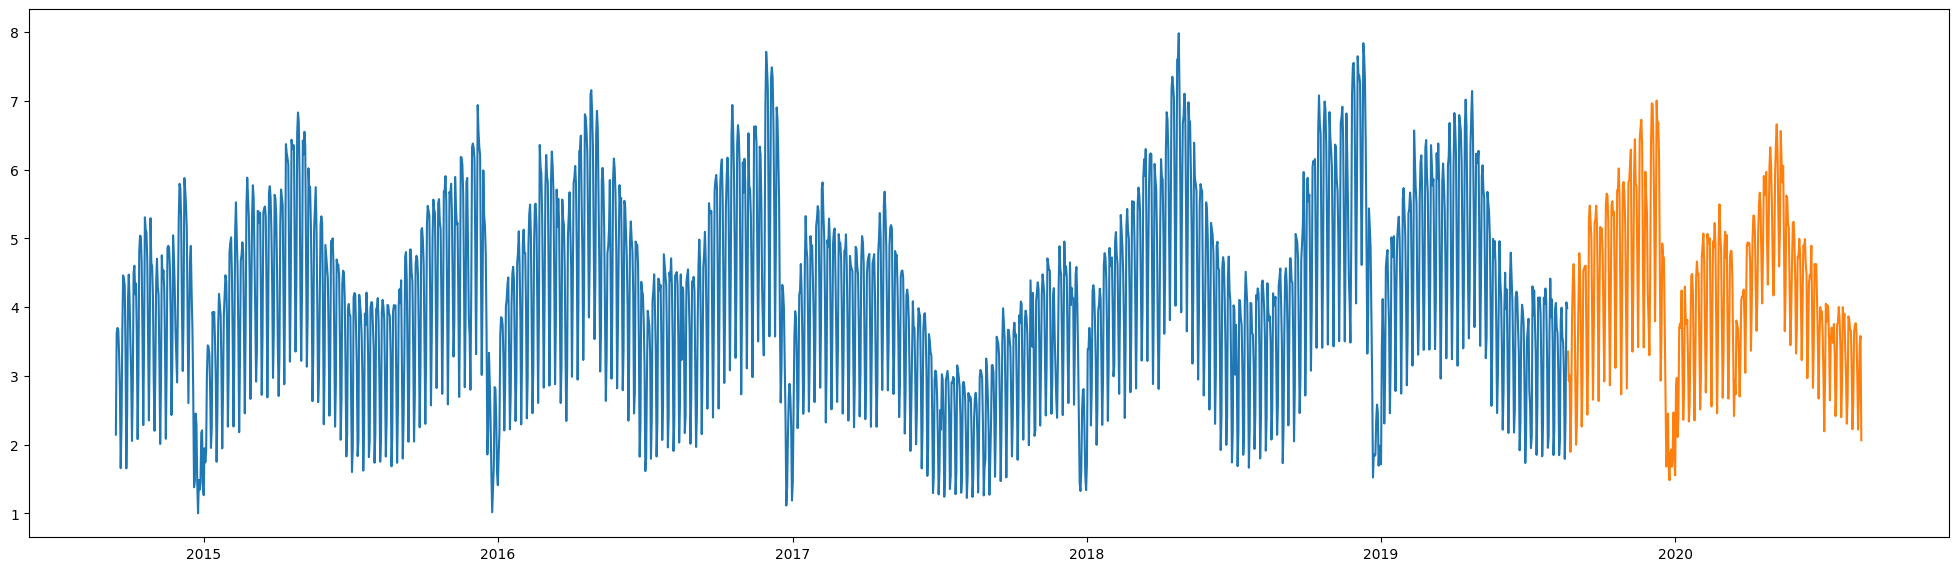

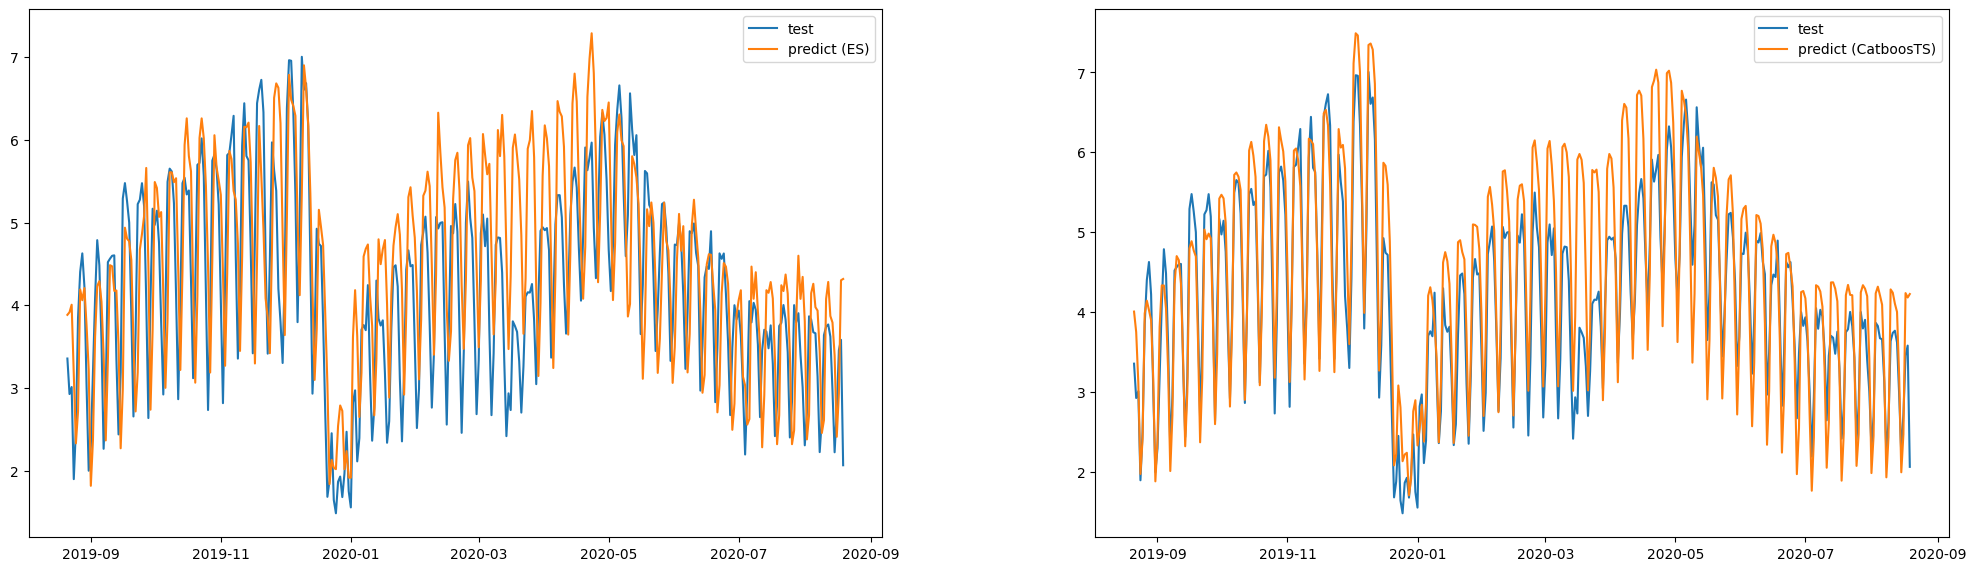

MSE(ES): 5365.124715086278
MSE: 0.2741014561319181
MAPE(ES): 19.984649481774397
MAPE: 0.1443145508951455


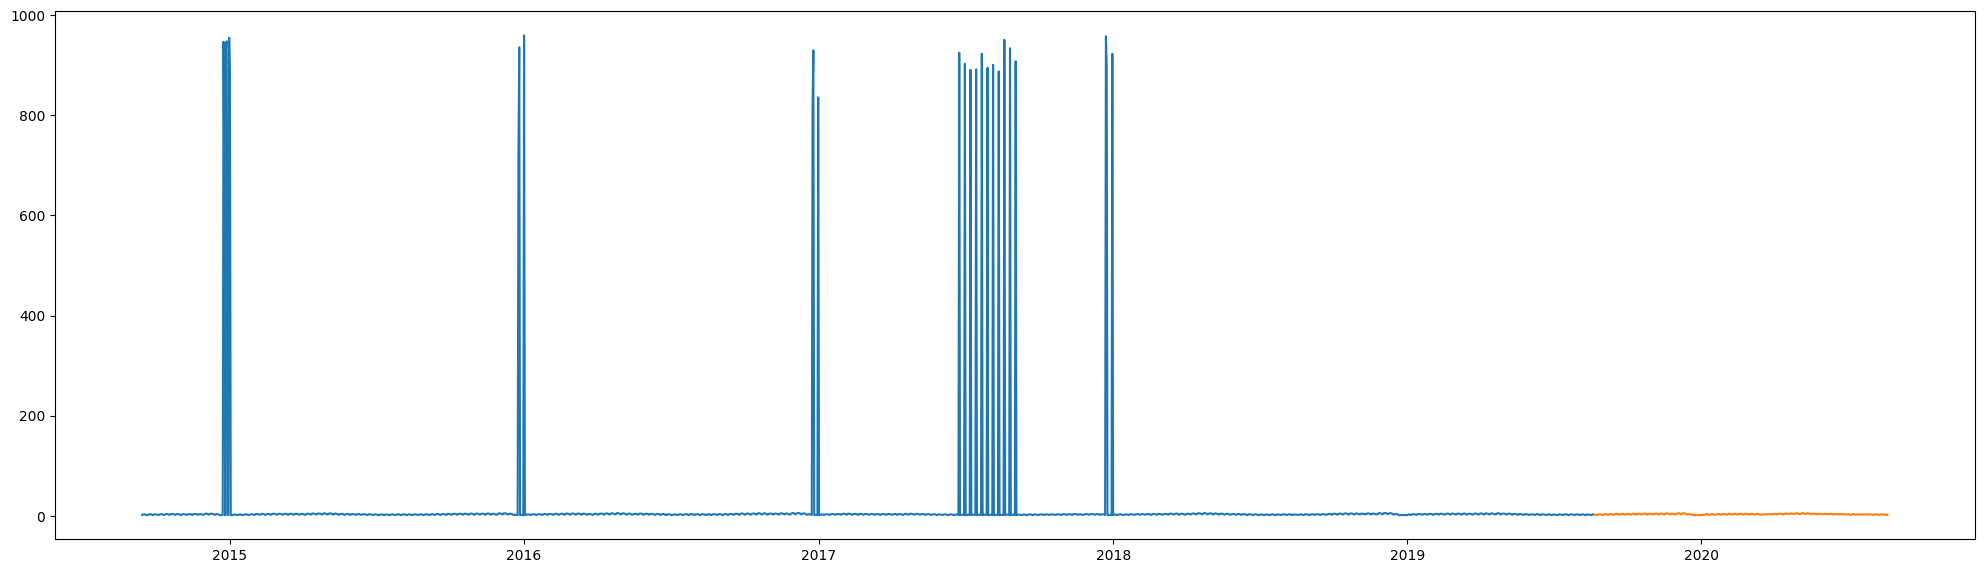

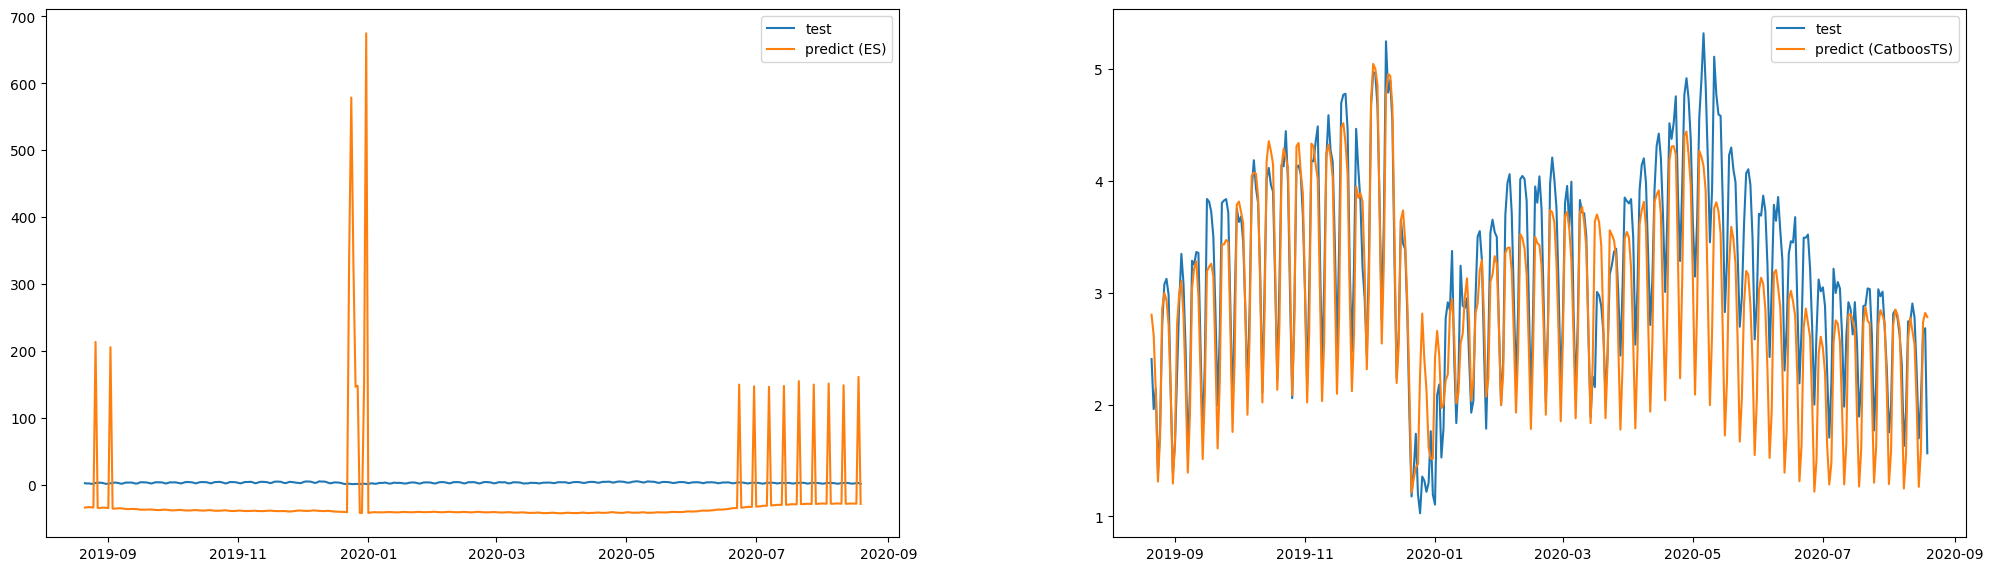

MSE(ES): 22988.564850875184
MSE: 6632.001740246767
MAPE(ES): 55.7795952636301
MAPE: 0.1624895213816416


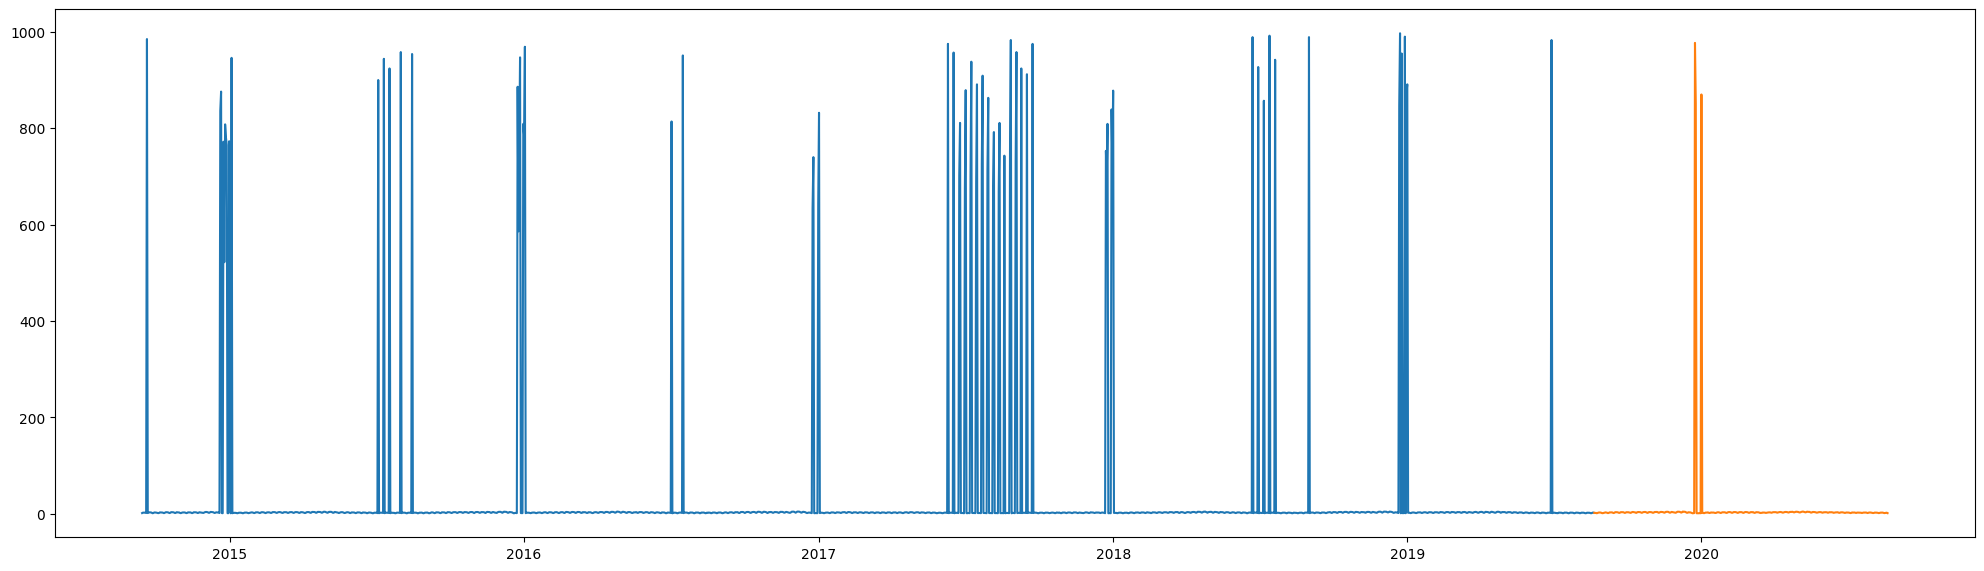

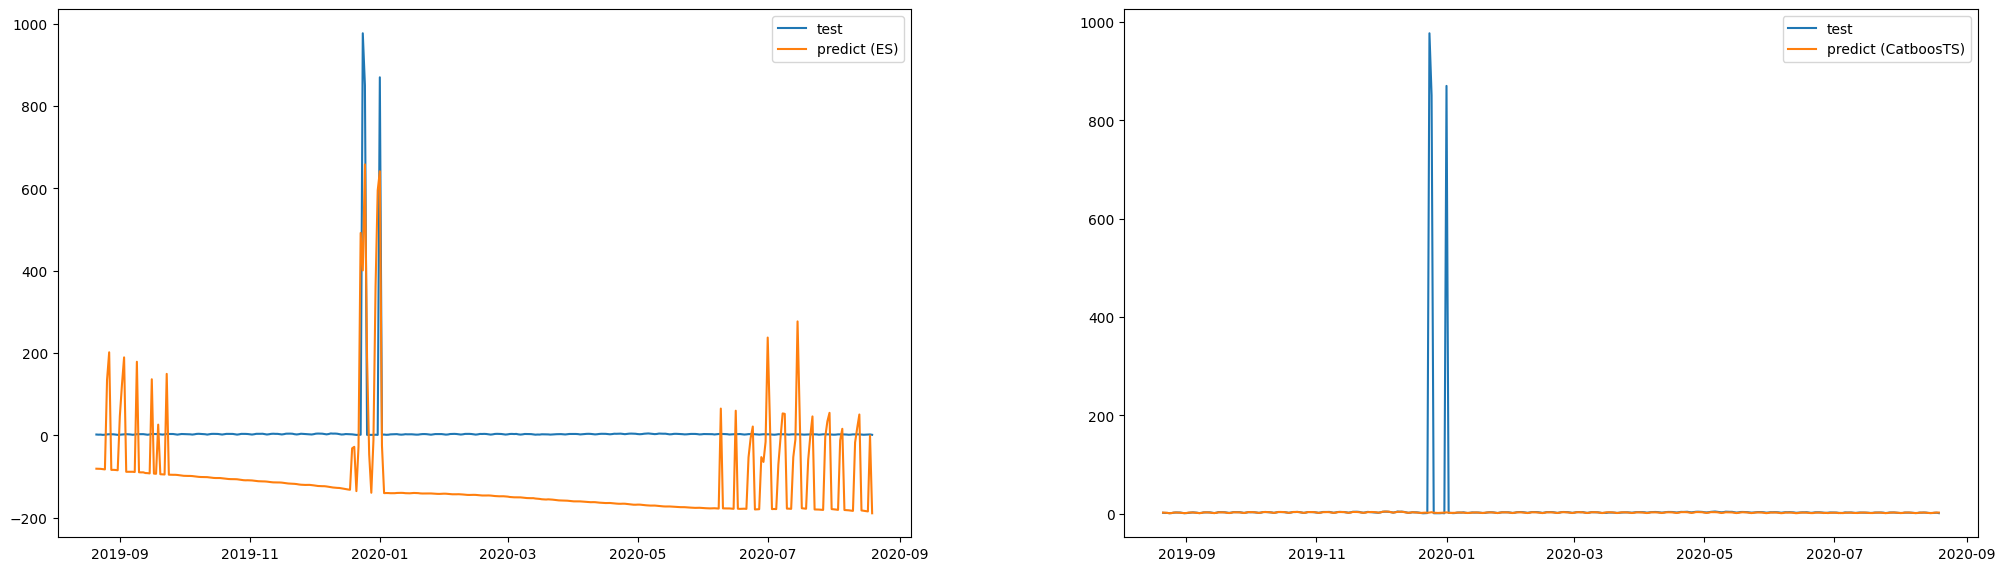

Optimization failed to converge. Check mle_retvals.


MSE(ES): 191185.53107935167
MSE: 11971.719837678234
MAPE(ES): 0.9004251103128085
MAPE: 0.1973228905735123


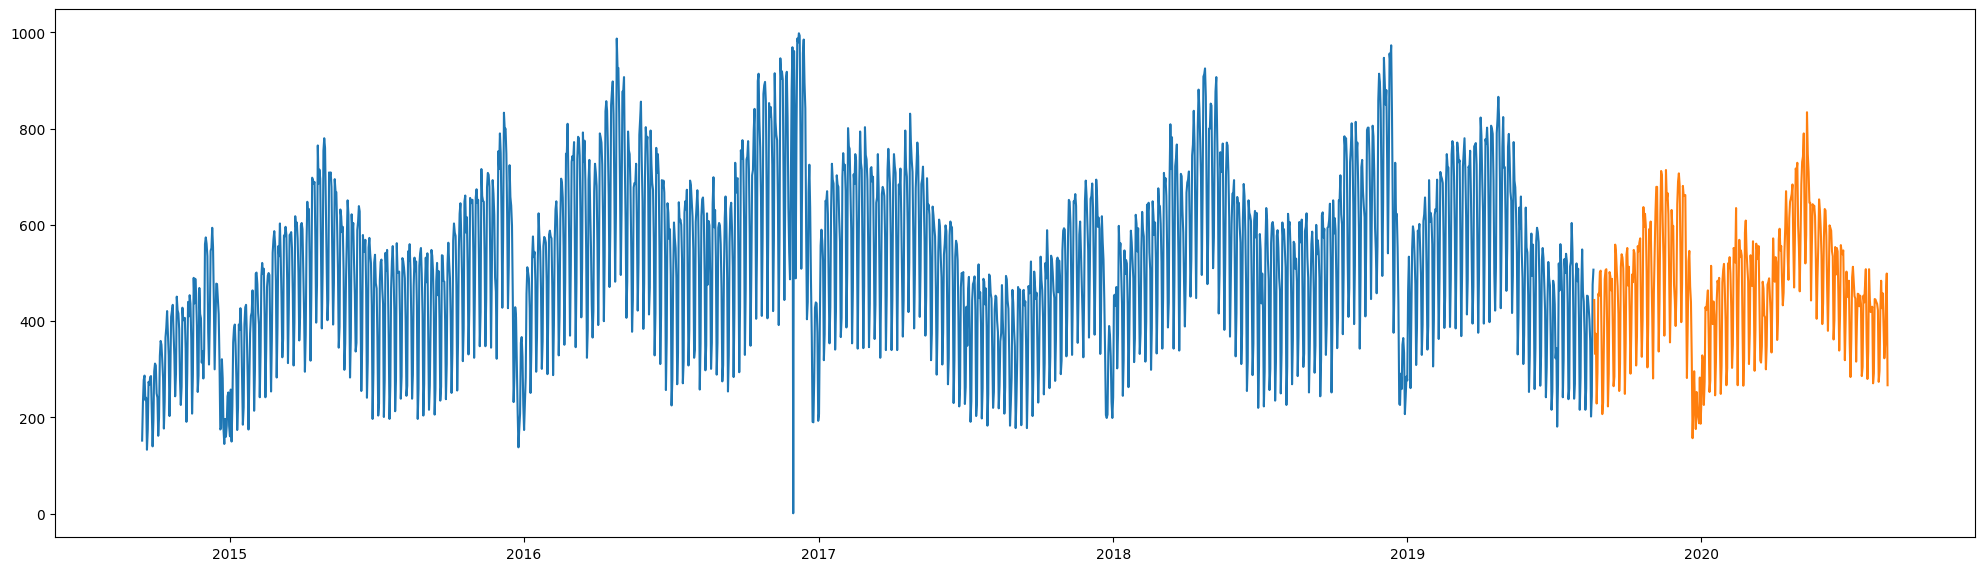

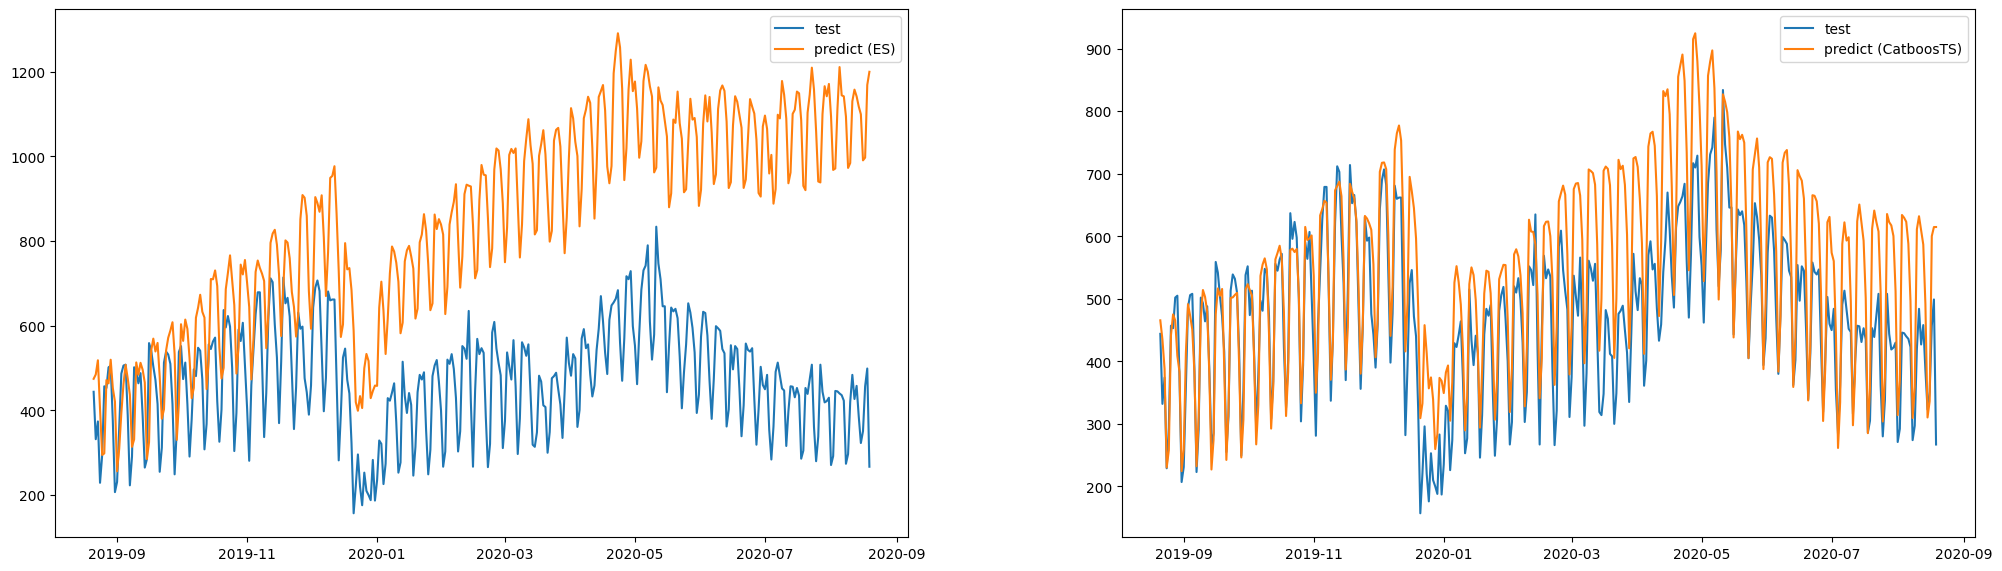

In [9]:
for target in targets:
    y_train, y_test = temporal_train_test_split(df[[target]].rename(columns={target:'y'}), test_size=365)
    index_train, index_test = y_train.index, y_test.index
    
    y_train_transform = transform.fit_transform(y_train)
    y_full_transform = y_train_transform.reindex(y_train_transform.index.union(y_test.index))
    X_full = featurizer.fit_transform(y_full_transform)

    X_full = X_full[lag_features + mean_features + std_features + fourier_features]
    X_train, X_test = X_full.loc[index_train], X_full.loc[index_test]

    model = CatBoostRegressor(loss_function="RMSE", has_time=True,)
    model.fit(X_train, y_train_transform, verbose=False)
    
    for idx in index_test:
        y_tmp = y_full_transform.loc[idx-pd.DateOffset(28+1):idx]
        X_test.loc[idx, to_update_features] = featurizer.transform(y_tmp).loc[idx, to_update_features]
        y_full_transform.loc[idx] = model.predict(X_test.loc[idx])
    
    y_pred = inverse_transform(transform, y_full_transform.loc[index_test])
    
    ES3 = ExponentialSmoothing(trend='add', seasonal='add', sp=365,).fit(y_train)
    y_pred['y1'] = ES3.predict(y_test.index)    
    
    print("MSE(ES):", mean_squared_error(y_test, y_pred.y1))
    print("MSE:", mean_squared_error(y_test, y_pred.y))
    print("MAPE(ES):", mean_absolute_percentage_error(y_test, y_pred.y1))
    print("MAPE:", mean_absolute_percentage_error(y_test, y_pred.y))
    
    plt.plot(y_train.index, y_train.y, label='train')
    plt.plot(y_test.index, y_test.y, label='test')
    plt.subplots_adjust(left=-1, bottom=-1, right=2, top=0.1, wspace=0.25, hspace=0.5)
    plt.show()
    
    fig, (ax0, ax1) = plt.subplots(nrows=1,ncols=2)

    ax0.plot(y_test.index, y_test.y, label='test')
    ax0.plot(y_pred.index, y_pred.y1, label='predict (ES)')
    ax0.legend()
    ax1.plot(y_test.index, y_test.y, label='test')
    ax1.plot(y_pred.index, y_pred.y, label='predict (CatboosTS)')
    ax1.legend()
    plt.subplots_adjust(left=-1, bottom=-1, right=2, top=0.1, wspace=0.25, hspace=0.5)
    plt.show()


#     explainer = sp.TreeExplainer(model)
#     shap_values = explainer.shap_values(X_train)

#     sp.summary_plot(shap_values, X_train, max_display=30 )
#     plt.show()